-----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Librerias

In [ ]:
import pandas as pd
import json
from collections import defaultdict
import re
import numpy as np
from utils.utilities import Tiempo
import utils.dataExtraction
import statistics
import keyword
import re
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que extrae los timestamps de inicio y fin de cada intentos de nivel
#### También extrae las estrellas obtenidas en cada intentos y cuantas veces se han intentado todos los niveles por cada jugador 

In [ ]:
def extraerTiemposPorNivelJugador(rawData):
    
    tiempos = defaultdict(defaultdict)
    intentosNecesarios = defaultdict(defaultdict)
    
    erLevel = re.compile(r'\blevel$\b')
    erIdLevel = re.compile(r'/')
    
    erInitialized = re.compile(r'\binitialized$\b')
    erCompleted = re.compile(r'\bcompleted$\b')
    
    for evento in rawData:
        verb = evento["verb"]["id"]
        obj = evento["object"]["definition"]["type"]
        name = evento["actor"]["name"]
        timestamp = evento["timestamp"]
        objectId = evento["object"]["id"]
        
        if erLevel.search(obj): #Si el objeto de la acción es un nivel
            levelCode = erIdLevel.split(objectId)[-1]
            if levelCode != "editor_level":
                if erInitialized.search(verb): #Si la acción es inicio o reinicio
                    if "result" in evento: #Significa que ha iniciado el nivel desde el menu
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode].append({"intentos" : 1, "success" : False})
                            tiempos[name][levelCode].append({"ini" : timestamp, "fin" : None, "stars" : ""})
                        else:
                            intentosNecesarios[name][levelCode] = [{"intentos" : 1, "success" : False}]
                            tiempos[name][levelCode] = [{"ini" : timestamp, "fin" : None, "stars" : ""}]
                    else:
                        intentosNecesarios[name][levelCode][-1]["intentos"] += 1
                elif erCompleted.search(verb):
                    if evento["result"]["score"]["raw"] > 0 :
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode][-1]["success"] = True
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]

                    elif evento["result"]["score"]["raw"] == -1:
                        if levelCode in tiempos[name]:
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]
    
    return {"tiempos" : tiempos, "intentosNecesarios" : intentosNecesarios}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que resta los timestamps de inicio y fin de cada intento de nivel para sacar la diferencia de tiempo

In [ ]:
def tiempoPorNiveles_Jugador(data):
    tiemposJugados = defaultdict(defaultdict)
    for player in data:
        for level in data[player]:
            for times in data[player][level]:
                if times["fin"] != None: #Si no se aborto el intento del nivel
                    timeDifference = Tiempo(times["ini"], times["fin"])
                    if level in tiemposJugados[player]:
                        tiemposJugados[player][level].append({"time" : timeDifference, "stars" : times["stars"]})
                    else:
                        tiemposJugados[player][level] = [{"time" : timeDifference, "stars" : times["stars"]}]
    return tiemposJugados

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que devuelve el tiempo medio necesario para completar un nivel y un diccionario con el tiempo empleado por cada jugador hasta completar el nivel
(El tiempo necesario para cada jugador es la suma de todos los tiempos hasta conseguir completar el nivel)
* También devuelve la media de estrellas y una lista de los niveles ordenados

In [ ]:
#TAMBIEN DEVUELVE EL TIEMPO INDIVIDUAL DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getMediaTiempoPorNivel(tiempos, soloPrimerExito = True, tiemposOrdenados = False):
    medias = defaultdict(list)
    mediasEstrellas = defaultdict(list)
    tiempoCompletarNivelIndividual = defaultdict(defaultdict)
    
    for player in tiempos:
        for level in tiempos[player]:
            tAux = Tiempo("0s")
            for t in tiempos[player][level]:
                if t["stars"] != -1:
                    if level in medias:
                        medias[level].append(int(tAux + t["time"]))
                        mediasEstrellas[level].append(int(t["stars"]))
                    else:
                        medias[level] = [int(tAux + t["time"])]
                        mediasEstrellas[level] = [int(t["stars"])]
                        
                    tiempoCompletarNivelIndividual[player][level] = tAux + t["time"]
                    if soloPrimerExito:
                        break
                elif t["stars"] == 0:
                    print("ALERTA")
                else:
                    tAux += t["time"]
    for m in medias:
        medias[m] = Tiempo(str(int(round(statistics.mean(medias[m]), 0))) + "s")
        
    for m in mediasEstrellas:
        mediasEstrellas[m] = statistics.mean(mediasEstrellas[m])
    
    listaNiveles = medias.keys()
    
    if tiemposOrdenados:
        medias = sorted(medias.items(), key=lambda x: x[1])
        mediasEstrellas = sorted(mediasEstrellas.items(), key=lambda x: x[1])
    else:
        medias = list(medias.items())
        mediasEstrellas = list(mediasEstrellas.items())
    
    return {"mediaTiempos" : medias, "mediaEstrellas" : mediasEstrellas, "listaNiveles" : listaNiveles, "tiemposIndividuales" : tiempoCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve un diccionario con clave: id Jugador y valor: ultimo nivel alcanzado

In [ ]:
def getUltimoNivelAlcanzado(tiempos):
    ultNivel = defaultdict()
    for player in tiempos:
        for level in tiempos[player]:
            ultNivel[player] = level
    return ultNivel

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve los intentos necesarios de cada jugador para completar un nivel al igual que los intentos medios

In [96]:
#TAMBIEN DEVUELVE LOS INTENTOS INDIVIDUALES DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getIntentosMedios_HastaCompletarNivel(intentosNecesarios, intentosOrdenados = False):
    intentosMedios = defaultdict(list)
    intentosCompletarNivelIndividual = defaultdict(defaultdict)
    
    for name in intentosNecesarios:
        for level in intentosNecesarios[name]:
            cont = 0
            for i in intentosNecesarios[name][level]:
                cont += i["intentos"]
                if i["success"] == True:
                    intentosMedios[level].append(cont)
                    intentosCompletarNivelIndividual[name][level] = cont
                    break
            
    for level in intentosMedios:
        intentosMedios[level] = round(statistics.mean(intentosMedios[level]), 2)
    
    if intentosOrdenados:
        intentosMedios = sorted(intentosMedios.items(), key=lambda x: x[1])
    else:
        intentosMedios = list(intentosMedios.items())
    return {"intentosMedios" : intentosMedios, "intentosIndividual" : intentosCompletarNivelIndividual}

In [97]:
def extraerArray(my_dict):
    nested_keys = []
    nested_values = []

    for k, v in my_dict.items():
        for nested_k, nested_v in v.items():
            nested_keys.append(nested_k)
            nested_values.append(nested_v)

    # create a dictionary with keys as the values of the nested_keys array
    nested_dict = defaultdict(list)
    for key, value in zip(nested_keys, nested_values):
        nested_dict[key].append(value)
    
    return nested_dict

In [98]:
def parseTiemposDictToInteger(data_dict):
    parsed_dict = {}

    for key, value in data_dict.items():
        parsed_list = []
        for element in value:
            parsed_list.append(int(element))
        parsed_dict[key] = parsed_list

    return parsed_dict

In [99]:
def create_boxplots(data_dict):
    # Group levels by category
    category_dict = {}
    for level, data in data_dict.items():
        category = level.split('_')[0]
        if category in category_dict:
            category_dict[category].append(data)
        else:
            category_dict[category] = [data]
    
    # Create boxplots for each category and add relevant information
    boxplots = []
    labels = []
    for i, (category, data_list) in enumerate(category_dict.items()):
        fig, ax = plt.subplots()
        bp = ax.boxplot(data_list, showfliers=True, sym='r+', patch_artist=True)
        ax.set_title(category)
        
        boxplots.append(bp)
        labels.append(category)
    
    # Set tick labels
    fig, ax = plt.subplots()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelrotation=45)
    
    return boxplots

In [100]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = None

In [101]:
JSONFile = open('./data/trazasOrdenadas.json')
rawData = json.load(JSONFile)
JSONFile.close()

resultados_Tiempos_Nivel_Jugador = extraerTiemposPorNivelJugador(rawData)

In [102]:
tiemposIntentosJugadores = tiempoPorNiveles_Jugador(resultados_Tiempos_Nivel_Jugador["tiempos"])
#pd.DataFrame(tiemposIntentosJugadores)

In [103]:
soloPrimerExito = True
tiemposOrdenados = False
tiemposMedios = getMediaTiempoPorNivel(tiemposIntentosJugadores, soloPrimerExito, tiemposOrdenados)
#pd.DataFrame(tiemposMedios["mediaTiempos"])
#pd.DataFrame(tiemposMedios["mediaEstrellas"])
#pd.DataFrame(tiemposMedios["listaNiveles"])
#pd.DataFrame(tiemposMedios["tiemposIndividuales"])

In [104]:
ultNivelAlcanzado = getUltimoNivelAlcanzado(tiemposMedios["tiemposIndividuales"])
#print(ultNivelAlcanzado)

In [105]:
intentosOrdenados = False
intentosMedios_Individual = getIntentosMedios_HastaCompletarNivel(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"], intentosOrdenados)
#pd.DataFrame(intentosMedios_Individual["intentosMedios"])
#pd.DataFrame(intentosMedios_Individual["intentosIndividual"])

In [106]:
tiemposList = extraerArray(tiemposMedios["tiemposIndividuales"])
intentosList = extraerArray(intentosMedios_Individual["intentosIndividual"])
#pd.DataFrame.from_dict(tiemposList, orient='index').transpose()
#pd.DataFrame.from_dict(intentosList, orient='index').transpose()

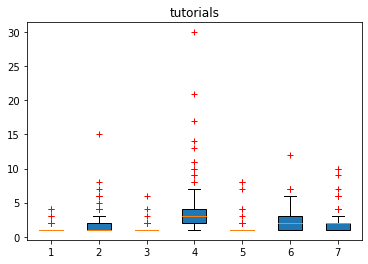

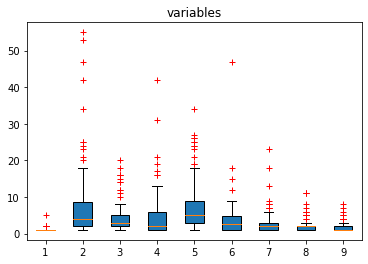

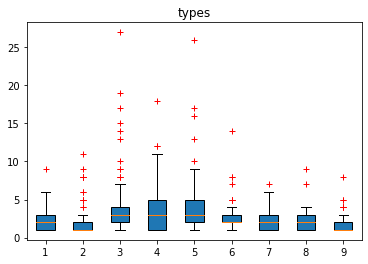

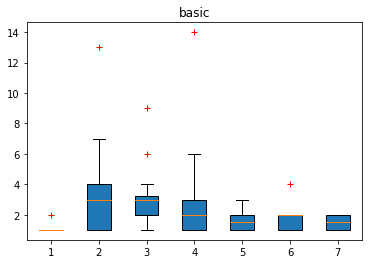

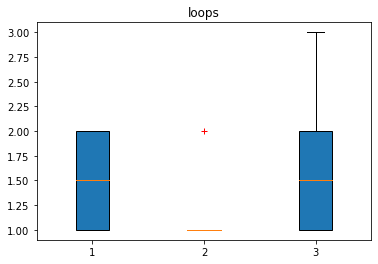

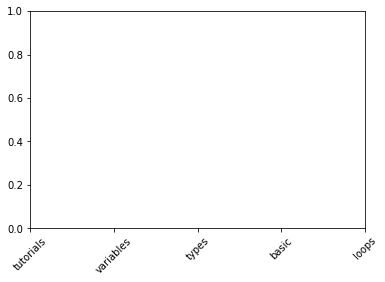

In [107]:
boxplotsIntentos = create_boxplots(intentosList)

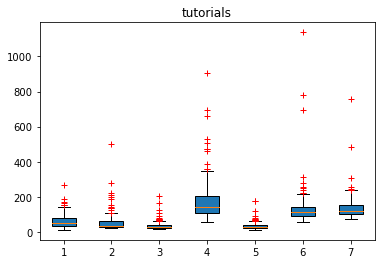

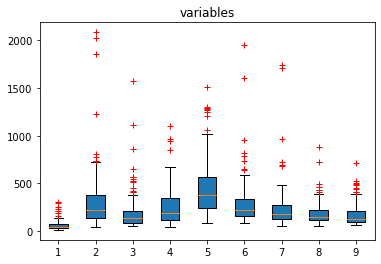

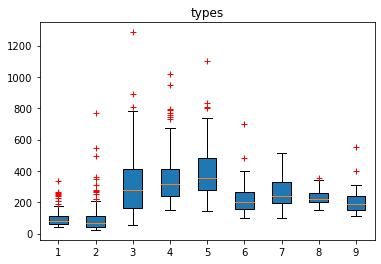

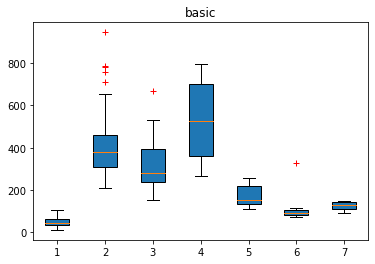

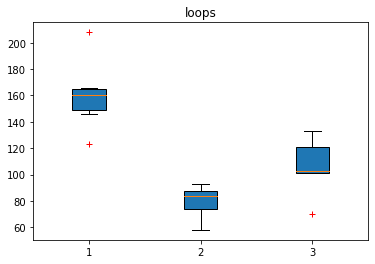

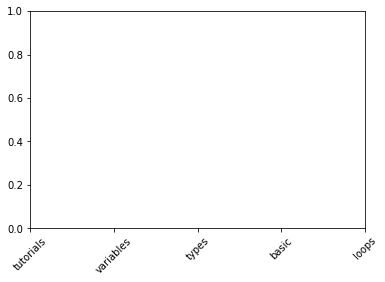

In [108]:
boxplotsTiempos = create_boxplots(parseTiemposDictToInteger(tiemposList))